# Analysis of the samples from parallel runs: 

In [1]:
using IntervalSets
using Distributions
using Random, LinearAlgebra, Statistics, Distributions, StatsBase, ArraysOfArrays
using JLD2
using ValueShapes
using TypedTables
using Measurements
using TypedTables
using HypothesisTests
using HDF5
using CSV

In [2]:
# using PyPlot
using Plots
pyplot()

Plots.PyPlotBackend()

In [3]:
using PyPlot

In [4]:
using Revise
using BAT

## Functions: 

In [5]:
function convert_to_typed_table(table)
    density_integral = [Measurements.measurement(parse.(Float64, split(v_run, " ± "))...) for v_run in table.density_integral]
    integration_cpu_time = collect(table.integration_cpu_time)
    sampling_cpu_time = collect(table.sampling_cpu_time)
    n_threads = collect(table.n_threads)
    worker_id = collect(table.worker_id)
    sum_weights = collect(table.sum_weights)
    samples_ind = [UnitRange(parse.(Int64, split(v_run, ":"))...) for v_run in table.samples_ind ]
    sampling_wc = [UnitRange(parse.(Int64, split(v_run, ":"))...) for v_run in table.sampling_wc ]
    integration_wc = [UnitRange(parse.(Int64, split(v_run, ":"))...) for v_run in table.integration_wc ]
    
    TypedTables.Table(
        density_integral=density_integral,
        integration_cpu_time=integration_cpu_time,
        sampling_cpu_time=sampling_cpu_time,
        n_threads=n_threads,
        worker_id=worker_id,
        sum_weights=sum_weights,
        samples_ind=samples_ind,
        sampling_wc=sampling_wc,
        integration_wc=integration_wc
    )
end

convert_to_typed_table (generic function with 1 method)

In [6]:
"""
Plot separated timelines of wall-clock times from different workers. 
"""
function plot_separated_timeline(data::T;figsize=(8,8)) where {T<:Table}
    
    minimum_timestamp = minimum([ts[1] for ts in data.sampling_wc])
    
    timestamps_shifted = [([
                data.sampling_wc[ts][1], data.sampling_wc[ts][end], 
                data.integration_wc[ts][1], data.integration_wc[ts][end]
                ] .- minimum_timestamp) .* 10^-9 for ts in 1:length(data.sampling_wc)]
    
    maximum_timestamp  = maximum(maximum.(timestamps_shifted))
    maximum_cpu_time = maximum([data.sampling_cpu_time..., data.integration_cpu_time...])
    
    proc_ids = collect(minimum(data.worker_id):maximum(data.worker_id))
    n_workers = length(proc_ids)
    
    x_min = 0
    x_max = maximum_timestamp
    y_min = 0
    y_max_tmp = Float64[]
    
    label_1 = "Sampling"
    label_2 = "Integration"
    
    @show n_workers, maximum(proc_ids)
    fig, ax = plt.subplots(n_workers,1, sharex=true, figsize=figsize)
    fig.subplots_adjust(hspace=0.0, wspace=0.00)
  
    for (i,j) in enumerate(timestamps_shifted)

        r1 = matplotlib.patches.Rectangle([j[1], 0.0], j[2]-j[1], data.sampling_cpu_time[i]/(j[2]-j[1]), fill=true, 
            linewidth=0.8, color="royalblue", alpha=0.5, label=label_1) 
        ax[data.worker_id[i] - 1].add_patch(r1)
        r2 = matplotlib.patches.Rectangle([j[3], 0.0], j[4]-j[3], data.integration_cpu_time[i]/(j[4]-j[3]), 
            fill=true, linewidth=0.8, color="peru", alpha=0.5, label=label_2) 
        ax[data.worker_id[i] - 1].add_patch(r2)

        push!(y_max_tmp, data.sampling_cpu_time[i]/(j[2]-j[1]))
        push!(y_max_tmp, data.integration_cpu_time[i]/(j[4]-j[3]))

        label_1 = "_nolegend_"
        label_2 = "_nolegend_"

    end

     ax[1].legend(loc="upper left", frameon=false, framealpha=0.8, ncol=1, bbox_to_anchor=(1.02, 1.0),)

    for i in 1:n_workers
        ax[i].set_xlim(x_min, x_max);
        ax[i].set_ylim(0, ceil(maximum(y_max_tmp)));
        ax[i].set_ylabel("w$i", labelpad=10,  size=10)

    #     ax[i].set_yticks(range(0, stop=floor(maximum(y_max_tmp)), step=1), minor=false)
        ax[i].grid(axis="y", which="both", alpha=0.2, )

        if i<n_workers
            ax[i].get_xaxis().set_visible(false) 
        end
    end

    fig.text(0.06, 0.5, "CPU time / Wall-clock time", va="center", rotation="vertical", size=12, weight="bold")
    ax[n_workers].set_xlabel("Wall-clock time [s]", labelpad=12,  size=12, weight="bold")
    
end

plot_separated_timeline

In [120]:
function get_cpu_time(name)
    csvfile = CSV.File(name)
    tt = Table(csvfile)
    table = convert_to_typed_table(tt)
    sum(table.integration_cpu_time)+sum(table.sampling_cpu_time)
end

function get_wc_time(name)
    csvfile = CSV.File(name)
    tt = Table(csvfile)
    table = convert_to_typed_table(tt)
    return (maximum([t[end] for t in table.integration_wc]) - minimum([t[1] for t in table.sampling_wc]))* 10^-9
end

function get_integrals(name)
    csvfile = CSV.File(name)
    tt = Table(csvfile)
    table = convert_to_typed_table(tt)
    return log(sum(table.density_integral)) 
end

get_integrals (generic function with 1 method)

## Load Data: 

In [7]:
prior = NamedTupleDist(a = [Uniform(-100,100) for i in 1:9]);

# Run #1: 

### Point:1-1

In [11]:
outp_tmp = bat_read("../data/Benchmark-1/samples1-1.hdf5")
samples_1_1 = varshape(prior).(outp_tmp);

In [12]:
csvfile = CSV.File("../data/Benchmark-1/table1-1.csv")
tt = Table(csvfile)
table_1_1 = convert_to_typed_table(tt);

In [ ]:
# plot(samples_1, vsel=[1,2,3,4,5], size=(1100,700), globalmode=true, localmode=true, 
#     upper=Dict("mean"=>false, "globalmode"=>false, "localmode"=>false,),
# )

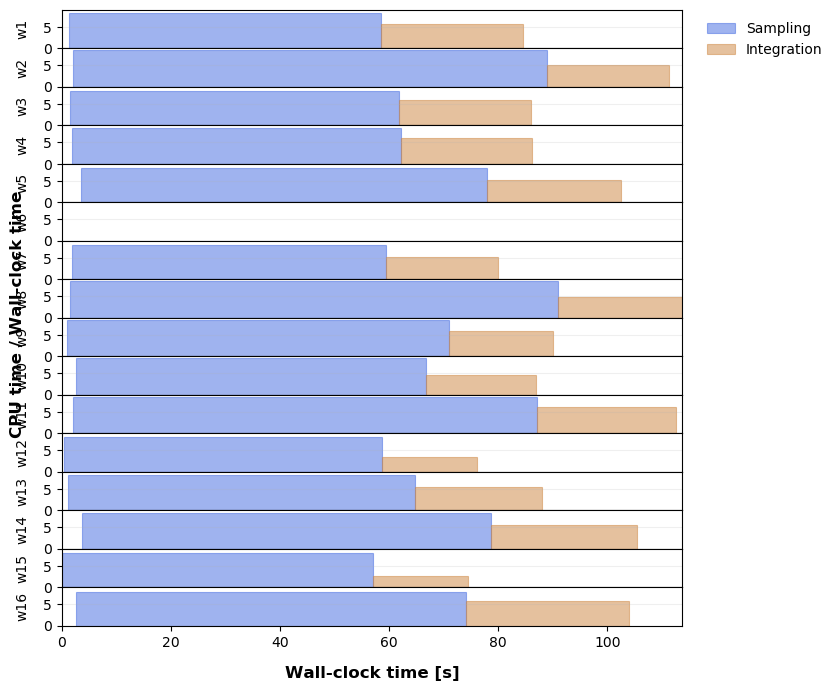

(n_workers, maximum(proc_ids)) = (16, 17)


PyObject Text(0.5, 25.00000000000001, 'Wall-clock time [s]')

In [13]:
plot_separated_timeline(table_1_1)

### Point:1-2

In [14]:
outp_tmp = bat_read("../data/Benchmark-1/samples1-2.hdf5")
samples_1_2 = varshape(prior).(outp_tmp);

In [15]:
csvfile = CSV.File("../data/Benchmark-1/table1-2.csv")
tt = Table(csvfile)
table_1_2 = convert_to_typed_table(tt);

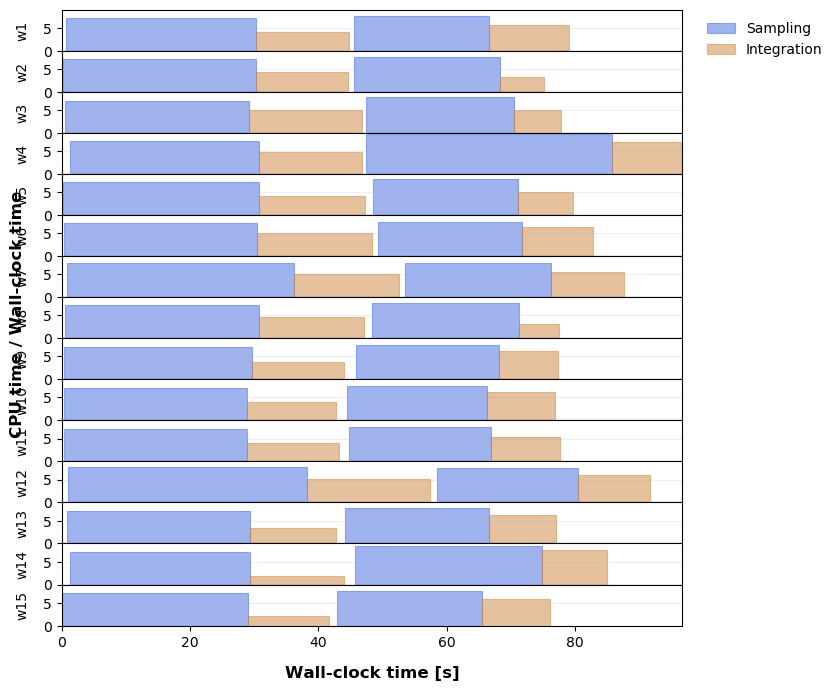

(n_workers, maximum(proc_ids)) = (15, 16)


PyObject Text(0.5, 25.00000000000001, 'Wall-clock time [s]')

In [16]:
plot_separated_timeline(table_1_2)

### Point:1-3

In [17]:
outp_tmp = bat_read("../data/Benchmark-1/samples1-3.hdf5")
samples_1_3 = varshape(prior).(outp_tmp);

In [18]:
csvfile = CSV.File("../data/Benchmark-1/table1-3.csv")
tt = Table(csvfile)
table_1_3 = convert_to_typed_table(tt);

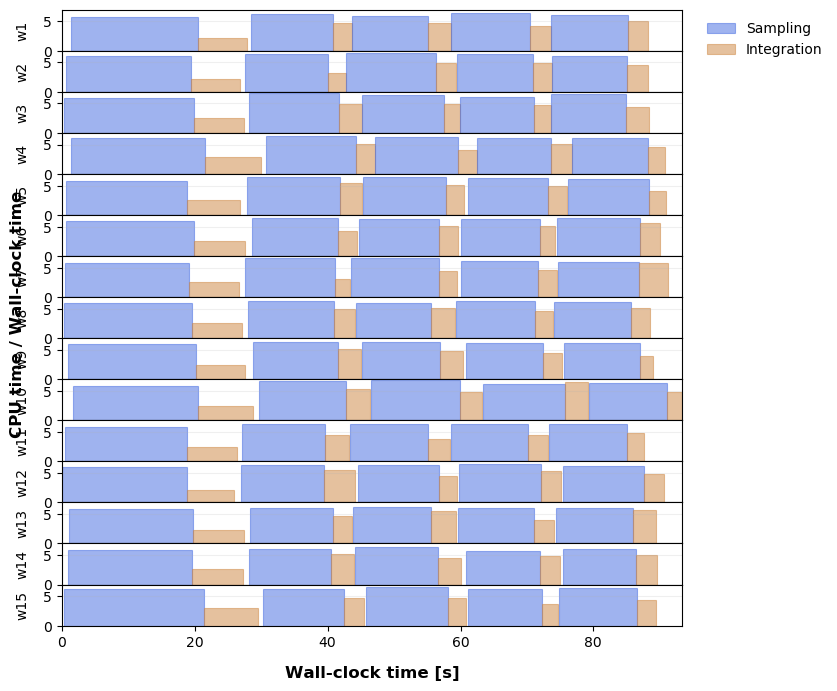

(n_workers, maximum(proc_ids)) = (15, 16)


PyObject Text(0.5, 25.00000000000001, 'Wall-clock time [s]')

In [19]:
plot_separated_timeline(table_1_3)

### Point:1-4

In [21]:
outp_tmp = bat_read("../data/Benchmark-1/samples1-4.hdf5")
samples_1_4 = varshape(prior).(outp_tmp);

In [22]:
csvfile = CSV.File("../data/Benchmark-1/table1-4.csv")
tt = Table(csvfile)
table_1_4 = convert_to_typed_table(tt);

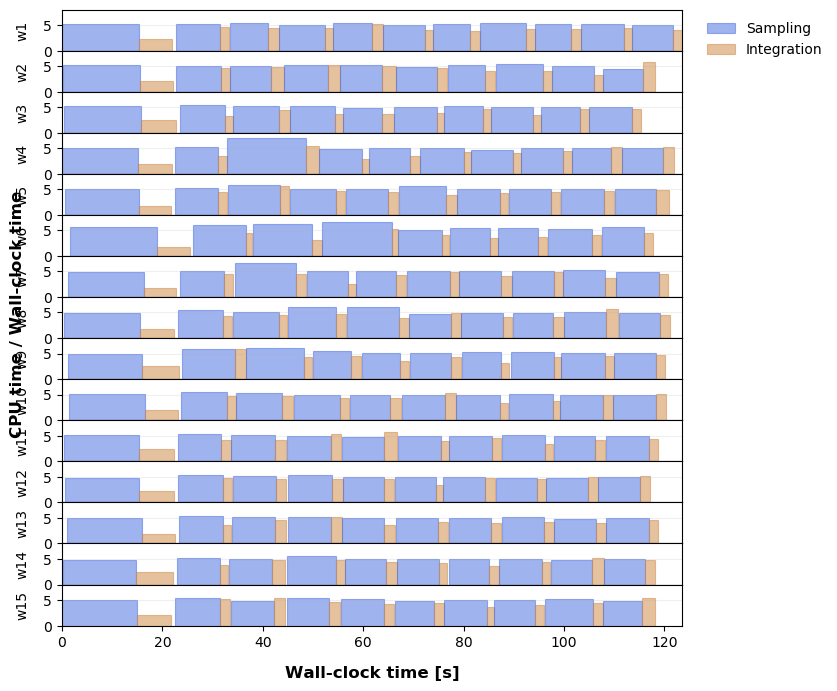

(n_workers, maximum(proc_ids)) = (15, 16)


PyObject Text(0.5, 25.00000000000001, 'Wall-clock time [s]')

In [23]:
plot_separated_timeline(table_1_4)

# Run #2: 

### Point:2-1

In [24]:
outp_tmp = bat_read("../data/Benchmark-1/samples2-1.hdf5")
samples_2_1 = varshape(prior).(outp_tmp);

In [25]:
csvfile = CSV.File("../data/Benchmark-1/table2-1.csv")
tt = Table(csvfile)
table_2_1 = convert_to_typed_table(tt);

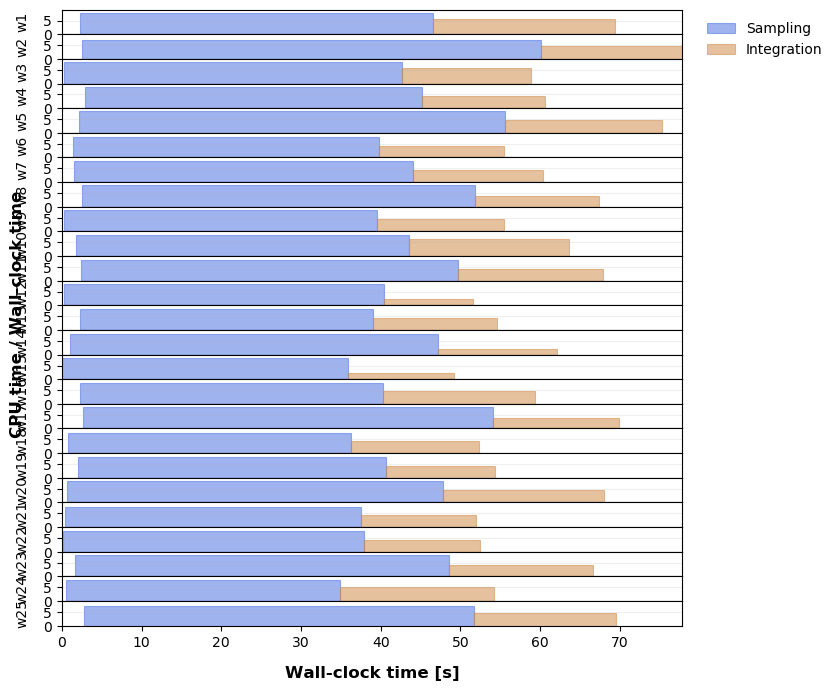

(n_workers, maximum(proc_ids)) = (25, 26)


PyObject Text(0.5, 25.00000000000001, 'Wall-clock time [s]')

In [26]:
plot_separated_timeline(table_2_1)

### Point:2-2

In [27]:
outp_tmp = bat_read("../data/Benchmark-1/samples2-2.hdf5")
samples_2_2 = varshape(prior).(outp_tmp);

In [28]:
csvfile = CSV.File("../data/Benchmark-1/table2-2.csv")
tt = Table(csvfile)
table_2_2 = convert_to_typed_table(tt);

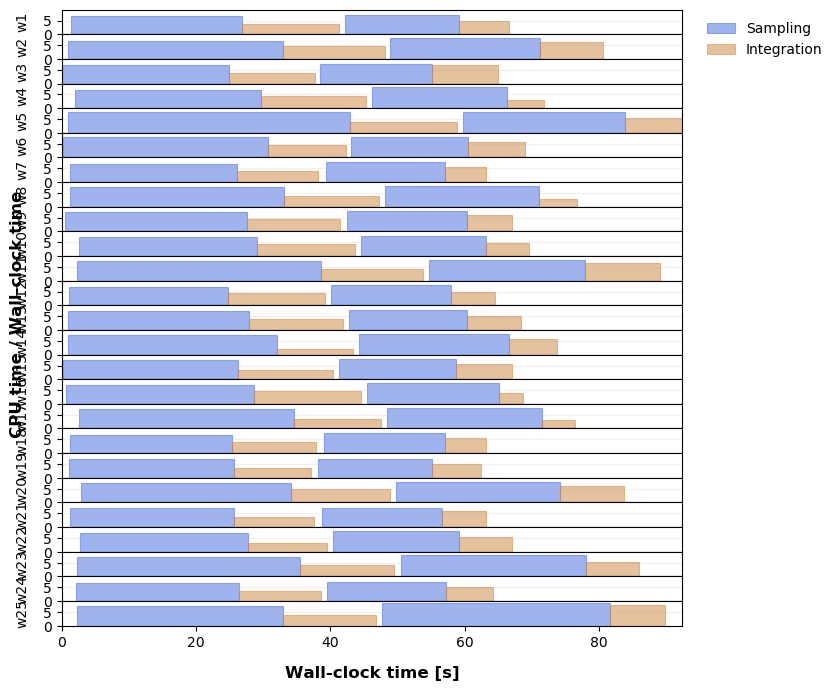

(n_workers, maximum(proc_ids)) = (25, 26)


PyObject Text(0.5, 25.00000000000001, 'Wall-clock time [s]')

In [29]:
plot_separated_timeline(table_2_2)

### Point:2-3

In [30]:
outp_tmp = bat_read("../data/Benchmark-1/samples2-3.hdf5")
samples_2_3 = varshape(prior).(outp_tmp);

In [31]:
csvfile = CSV.File("../data/Benchmark-1/table2-3.csv")
tt = Table(csvfile)
table_2_3 = convert_to_typed_table(tt);

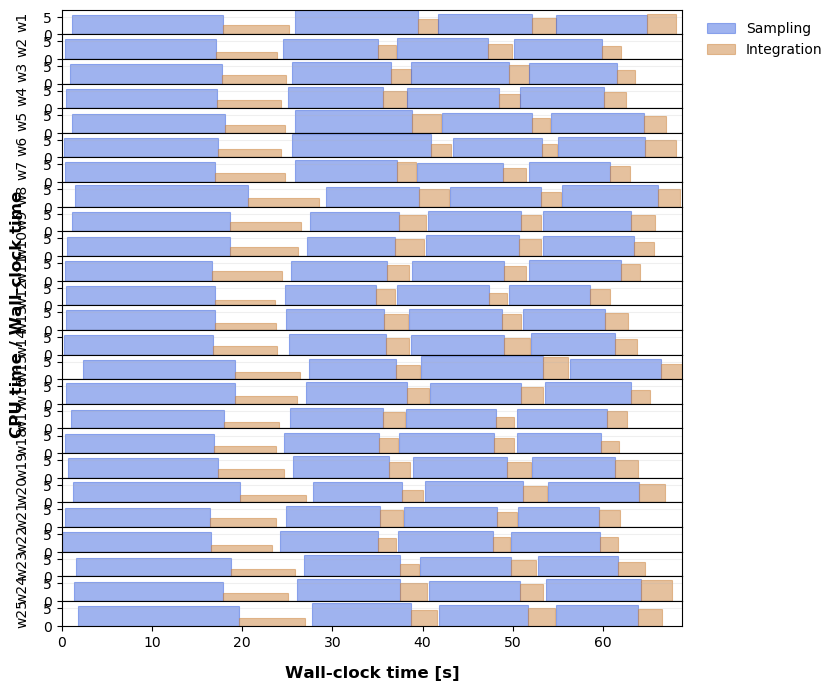

(n_workers, maximum(proc_ids)) = (25, 26)


PyObject Text(0.5, 25.00000000000001, 'Wall-clock time [s]')

In [32]:
plot_separated_timeline(table_2_3)

### Point:2-4

In [33]:
outp_tmp = bat_read("../data/Benchmark-1/samples2-4.hdf5")
samples_2_4 = varshape(prior).(outp_tmp);

In [34]:
csvfile = CSV.File("../data/Benchmark-1/table2-4.csv")
tt = Table(csvfile)
table_2_4 = convert_to_typed_table(tt);

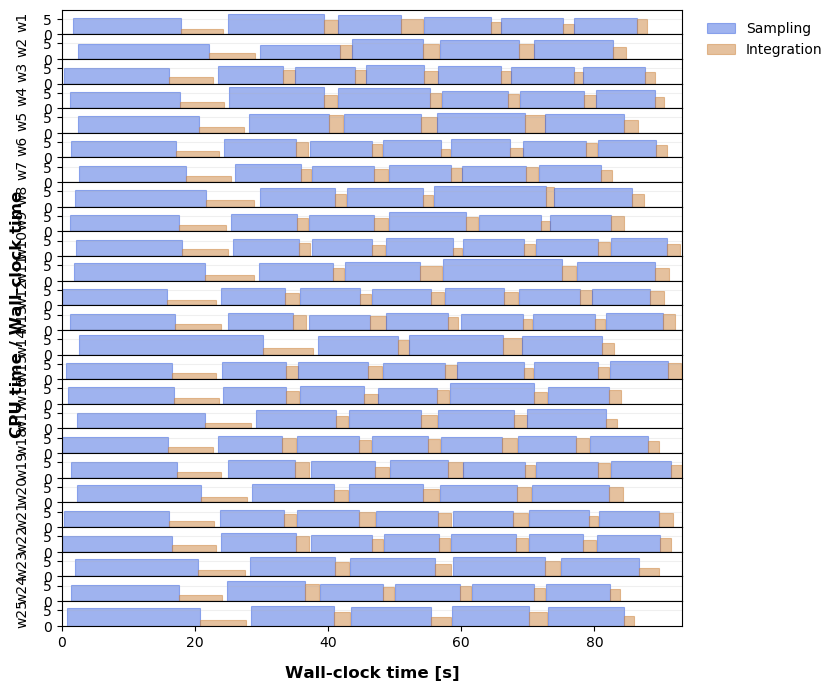

(n_workers, maximum(proc_ids)) = (25, 26)


PyObject Text(0.5, 25.00000000000001, 'Wall-clock time [s]')

In [35]:
plot_separated_timeline(table_2_4)

# Run #3: 

### Point:3-1

In [36]:
outp_tmp = bat_read("../data/Benchmark-1/samples3-1.hdf5")
samples_3_1 = varshape(prior).(outp_tmp);

In [37]:
csvfile = CSV.File("../data/Benchmark-1/table3-1.csv")
tt = Table(csvfile)
table_3_1 = convert_to_typed_table(tt);

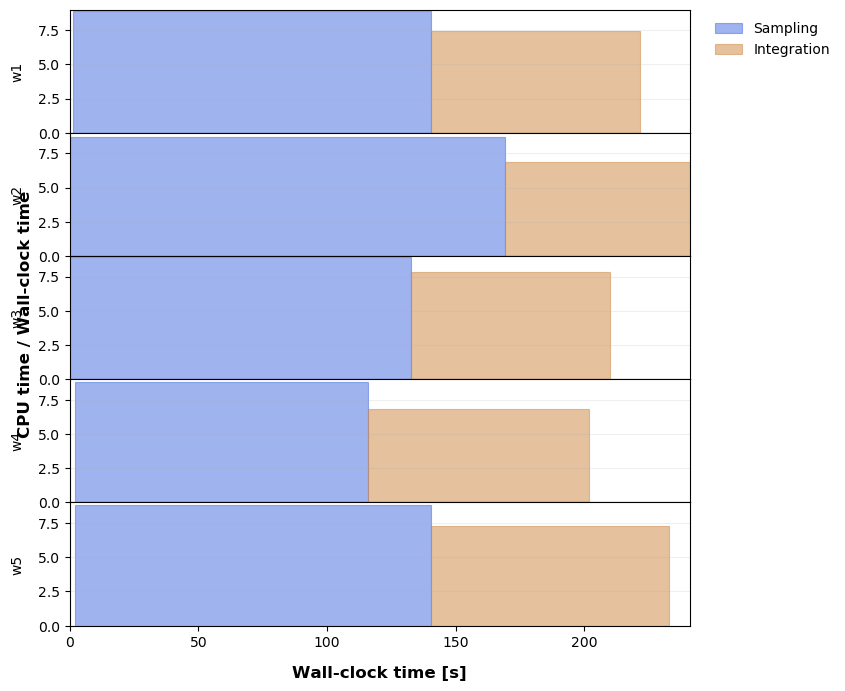

(n_workers, maximum(proc_ids)) = (5, 6)


PyObject Text(0.5, 25.00000000000001, 'Wall-clock time [s]')

In [38]:
plot_separated_timeline(table_3_1)

### Point:3-2

In [39]:
outp_tmp = bat_read("../data/Benchmark-1/samples3-2.hdf5")
samples_3_2 = varshape(prior).(outp_tmp);

In [40]:
csvfile = CSV.File("../data/Benchmark-1/table3-2.csv")
tt = Table(csvfile)
table_3_2 = convert_to_typed_table(tt);

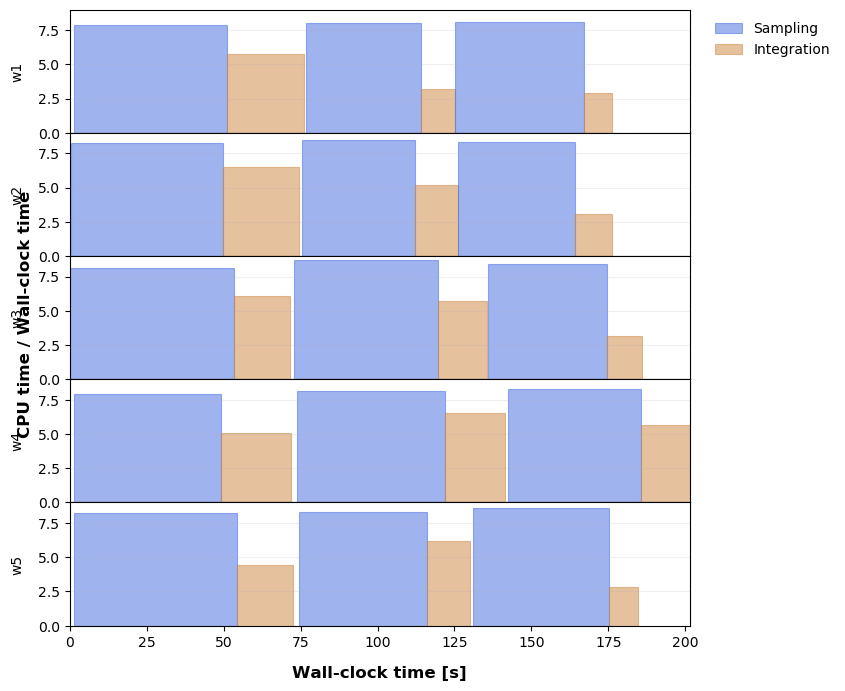

(n_workers, maximum(proc_ids)) = (5, 6)


PyObject Text(0.5, 25.00000000000001, 'Wall-clock time [s]')

In [41]:
plot_separated_timeline(table_3_2)

### Point:3-3

In [42]:
outp_tmp = bat_read("../data/Benchmark-1/samples3-3.hdf5")
samples_3_3 = varshape(prior).(outp_tmp);

In [43]:
csvfile = CSV.File("../data/Benchmark-1/table3-3.csv")
tt = Table(csvfile)
table_3_3 = convert_to_typed_table(tt);

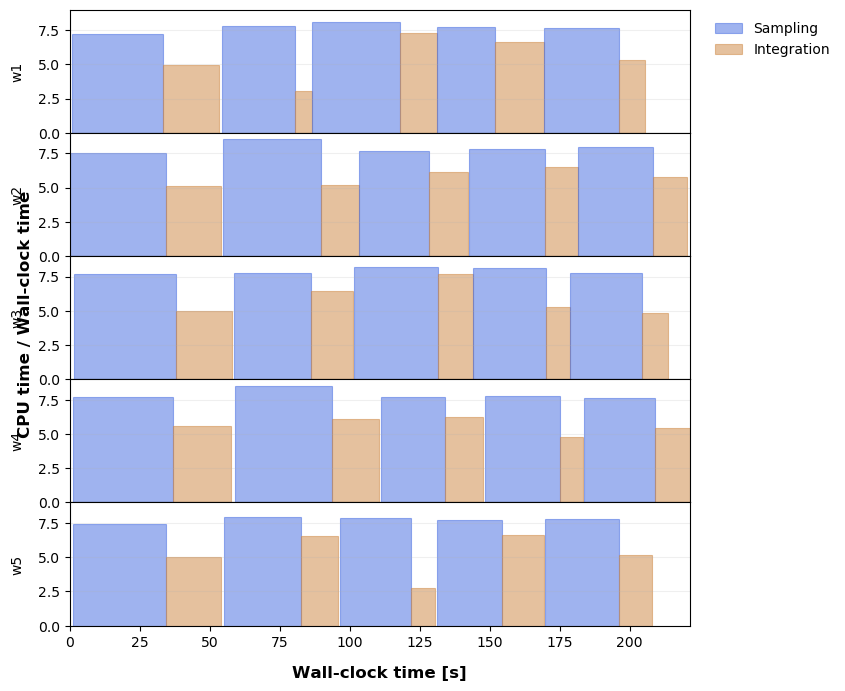

(n_workers, maximum(proc_ids)) = (5, 6)


PyObject Text(0.5, 25.00000000000001, 'Wall-clock time [s]')

In [44]:
plot_separated_timeline(table_3_3)

### Point:3-4

In [45]:
outp_tmp = bat_read("../data/Benchmark-1/samples3-4.hdf5")
samples_3_4 = varshape(prior).(outp_tmp);

In [46]:
csvfile = CSV.File("../data/Benchmark-1/table3-4.csv")
tt = Table(csvfile)
table_3_4 = convert_to_typed_table(tt);

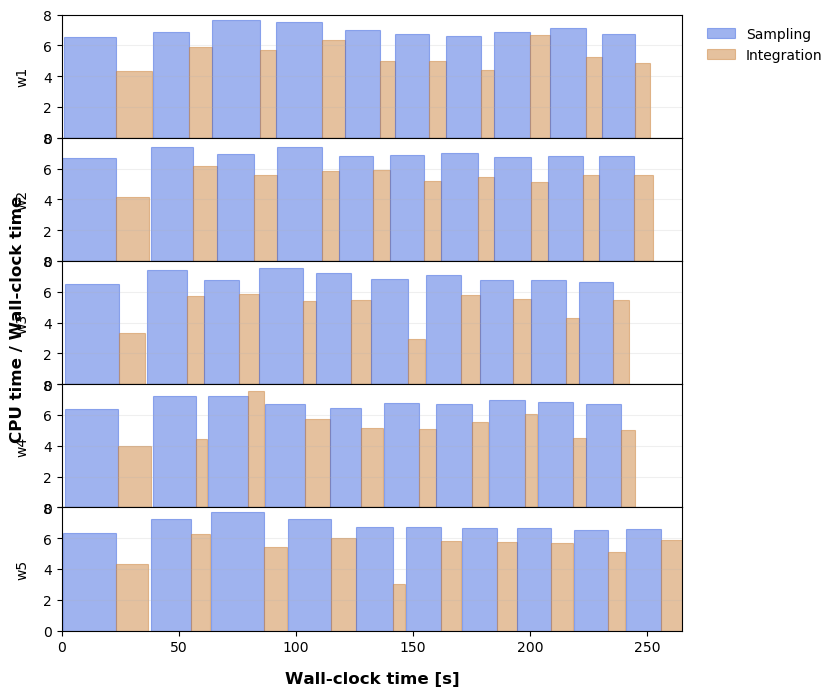

(n_workers, maximum(proc_ids)) = (5, 6)


PyObject Text(0.5, 25.00000000000001, 'Wall-clock time [s]')

In [47]:
plot_separated_timeline(table_3_4)

### Point:3-5

In [48]:
outp_tmp = bat_read("../data/Benchmark-1/samples3-5.hdf5")
samples_3_5 = varshape(prior).(outp_tmp);

In [49]:
csvfile = CSV.File("../data/Benchmark-1/table3-5.csv")
tt = Table(csvfile)
table_3_5 = convert_to_typed_table(tt);

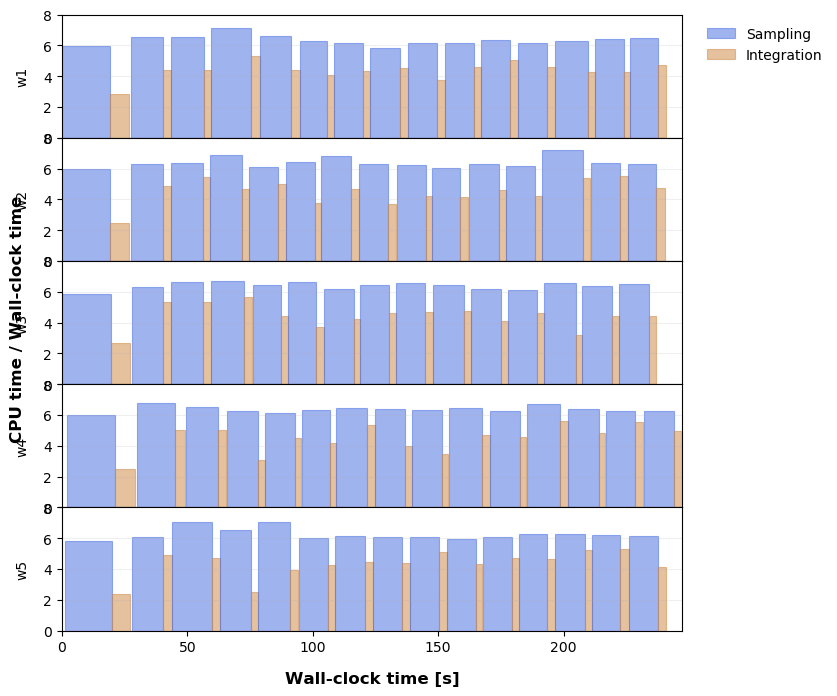

(n_workers, maximum(proc_ids)) = (5, 6)


PyObject Text(0.5, 25.00000000000001, 'Wall-clock time [s]')

In [50]:
plot_separated_timeline(table_3_5)

### Point:3-6

In [51]:
outp_tmp = bat_read("../data/Benchmark-1/samples3-6.hdf5")
samples_3_6 = varshape(prior).(outp_tmp);

In [52]:
csvfile = CSV.File("../data/Benchmark-1/table3-6.csv")
tt = Table(csvfile)
table_3_6 = convert_to_typed_table(tt);

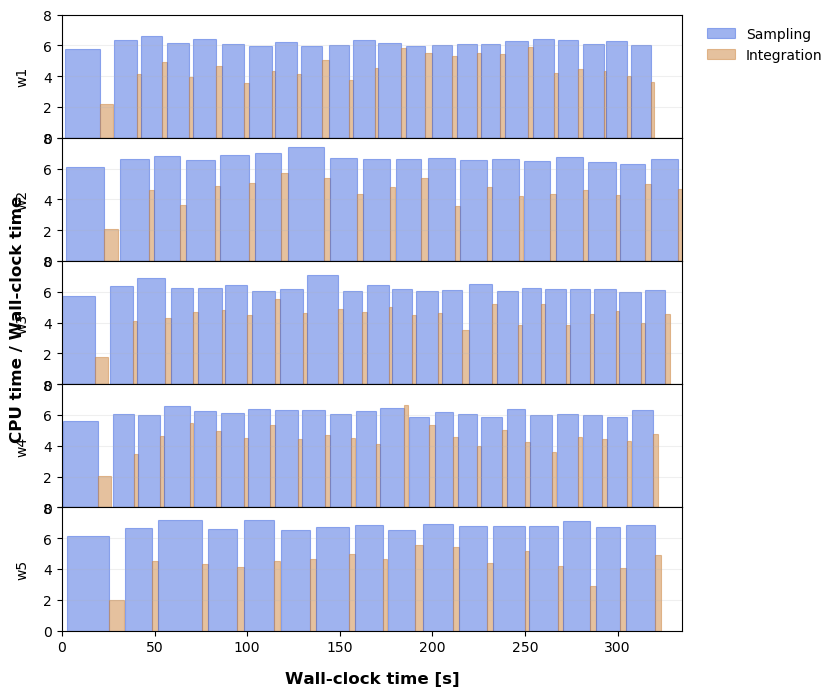

(n_workers, maximum(proc_ids)) = (5, 6)


PyObject Text(0.5, 25.00000000000001, 'Wall-clock time [s]')

In [53]:
plot_separated_timeline(table_3_6)

### Point:3-7

In [54]:
outp_tmp = bat_read("../data/Benchmark-1/samples3-7.hdf5")
samples_3_7 = varshape(prior).(outp_tmp);

In [55]:
csvfile = CSV.File("../data/Benchmark-1/table3-7.csv")
tt = Table(csvfile)
table_3_7 = convert_to_typed_table(tt);

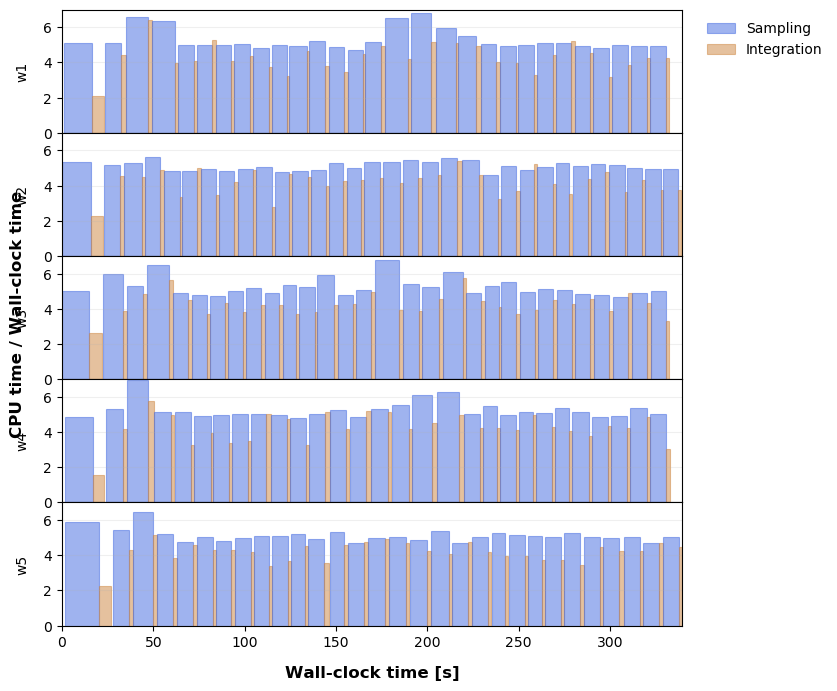

(n_workers, maximum(proc_ids)) = (5, 6)


PyObject Text(0.5, 25.00000000000001, 'Wall-clock time [s]')

In [56]:
plot_separated_timeline(table_3_7)

# Analysis: 

In [91]:
names_1 = ["table1-1.csv", "table1-2.csv", "table1-3.csv", "table1-4.csv"]
names_2 = ["table2-1.csv", "table2-2.csv", "table2-3.csv", "table2-4.csv"]
names_3 = ["table3-1.csv", "table3-2.csv", "table3-3.csv", "table3-4.csv", "table3-5.csv", "table3-6.csv", "table3-7.csv"]

path = "../data/Benchmark-1/"


"../data/Benchmark-1/"

In [139]:
run_1 = Table(
    ind = [1,2,3,4], 
    n_chains=[10, 10, 10, 10], 
    n_samples = [10^5, 5*10^4, 2*10^4, 10^4], 
    n_subsets = [15,30,75,150],
    cpu_time = [get_cpu_time(t) for t in path .* names_1],
    wc_time = [get_wc_time(t) for t in path .* names_1],
    integral = [get_integrals(t).val for t in path .* names_1],
    integral_err = [get_integrals(t).err for t in path .* names_1],
)


run_2 = Table(
    ind = [1,2,3,4], 
    n_chains=[10, 10, 10, 10], 
    n_samples = [6*10^4, 3*10^4, 15*10^3, 10^4], 
    n_subsets = [25,50,100,150],
    cpu_time = [get_cpu_time(t) for t in path .* names_2],
    wc_time = [get_wc_time(t) for t in path .* names_2],
    integral = [get_integrals(t).val for t in path .* names_2],
    integral_err = [get_integrals(t).err for t in path .* names_2],
)

run_3 = Table(
    ind = [1,2,3,4,5,6,7], 
    n_chains=[10, 10, 10, 10, 10, 10, 10], 
    n_samples = [3*10^5, 10^5, 6*10^4, 3*10^4, 2*10^4, 15*10^3, 10^4], 
    n_subsets = [5, 15, 25, 50, 75, 100,150],
    cpu_time = [get_cpu_time(t) for t in path .* names_3],
    wc_time = [get_wc_time(t) for t in path .* names_3],
    integral = [get_integrals(t).val for t in path .* names_3],
    integral_err = [get_integrals(t).err for t in path .* names_3],
)

Table with 8 columns and 7 rows:
     ind  n_chains  n_samples  n_subsets  cpu_time  wc_time  integral  ⋯
   ┌────────────────────────────────────────────────────────────────────
 1 │ 1    10        300000     5          9077.69   241.025  -47.6845  ⋯
 2 │ 2    10        100000     15         6755.84   201.431  -47.6881  ⋯
 3 │ 3    10        60000      25         7522.07   221.421  -47.6873  ⋯
 4 │ 4    10        30000      50         7916.53   265.042  -47.6832  ⋯
 5 │ 5    10        20000      75         7057.77   247.246  -47.6863  ⋯
 6 │ 6    10        15000      100        9709.87   334.702  -47.6853  ⋯
 7 │ 7    10        10000      150        8342.08   339.453  -47.6868  ⋯

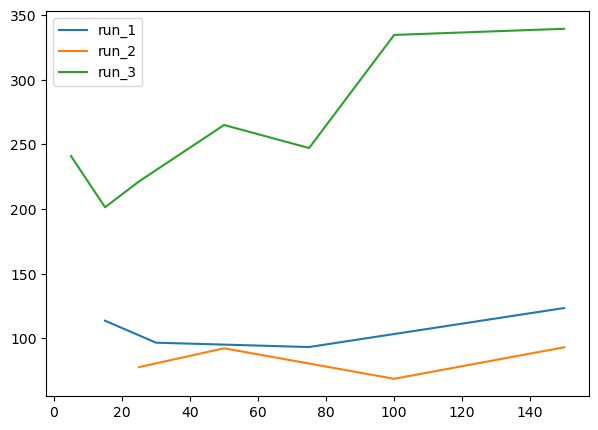

PyObject <matplotlib.legend.Legend object at 0x7f8d1d2be790>

In [140]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

ax.plot(run_1.n_subsets, run_1.wc_time, label="run_1")
ax.plot(run_2.n_subsets, run_2.wc_time, label="run_2")
ax.plot(run_3.n_subsets, run_3.wc_time, label="run_3")

ax.legend()

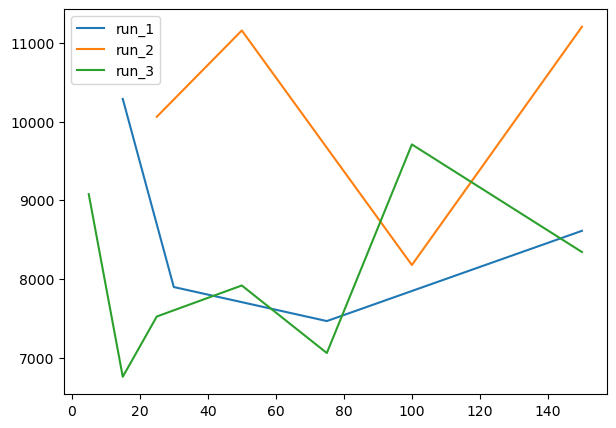

PyObject <matplotlib.legend.Legend object at 0x7f8d2d35e050>

In [141]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

ax.plot(run_1.n_subsets, run_1.cpu_time, label="run_1")
ax.plot(run_2.n_subsets, run_2.cpu_time, label="run_2")
ax.plot(run_3.n_subsets, run_3.cpu_time, label="run_3")

ax.legend()

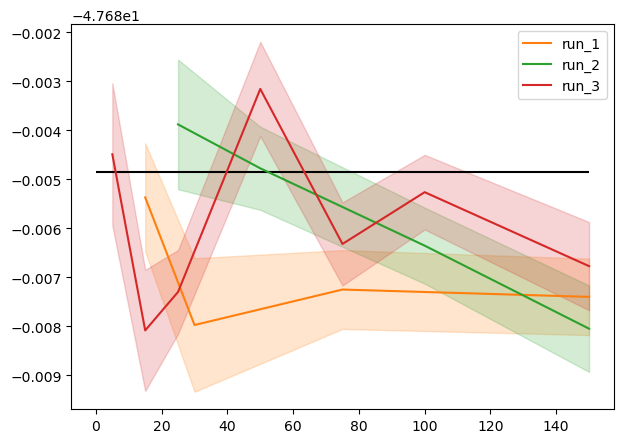

PyObject <matplotlib.legend.Legend object at 0x7f8d4b9d2690>

In [154]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

ax.plot(run_1.n_subsets, run_1.integral, color="C1", label="run_1")
ax.fill_between(run_1.n_subsets,run_1.integral .- run_1.integral_err, run_1.integral .+ run_1.integral_err, alpha=0.2, color="C1", )

ax.plot(run_2.n_subsets, run_2.integral, color="C2",  label="run_2")
ax.fill_between(run_2.n_subsets,run_2.integral .- run_2.integral_err, run_2.integral .+ run_2.integral_err, alpha=0.2, color="C2", )

ax.plot(run_3.n_subsets, run_3.integral, color="C3", label="run_3")
ax.fill_between(run_3.n_subsets,run_3.integral .- run_3.integral_err, run_3.integral .+ run_3.integral_err, alpha=0.2, color="C3", )

ax.hlines([-47.684856298932324], 0, 150)

ax.legend()